<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/Tarea%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: Redes Generativas Adversarias

### MDS7203 Modelos Generativos Profundos

**Nombre:**
- Carolina Nuñez
- Hecmar Taucare

**Fecha de entrega:**

En esta segunda tarea, el objetivo es implementar el modelo [Pix2Pix](https://arxiv.org/abs/1611.07004), el cual es un modelo tipo GAN que permite realizar tareas de image-to-image translation. Dado que las GANs suelen sufrir de inestabilidades durante el entrenamiento, esta tarea evaluará, además, el uso de heurísticas sencillas que se suelen usar al entrenar este tipo de modelos.

Algunas instrucciones generales:
- Se sugiere usar herramientas como ChatGPT o Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- La tarea debe ser realizada en Google Colab.
- La tarea tiene 3 partes, y cada parte vale lo mismo.
- Se recomienda leer la tarea completa antes de comenzar su desarrollo.

In [1]:
import os
import zipfile
import gdown
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Parte 1 (datos de entrenamiento)

En esta primera parte se implementará la clase `MapsDataset` que se utilizará para definir el dataset de entrenamiento para el modelo `pix2pix`. Los datos de entrenamiento que se usarán en este modelo corresponden al dataset `maps`, el cual fue construido especialmente para el modelo `pix2pix`. Cada muestra de este dataset consiste en pares de imágenes de la forma $(x_0,x_1)$, donde $x_0$ es una foto aérea de alguna región de Nueva York y $x_1$ es la imagen de un mapa asociado a la región que cubre $x_1$.

Con este dataset definido, el objetivo en las partes 2 y 3 de la tarea será implementar y entrenar un modelo `pix2pix` que aprenda a transformar una imagen satelital $x_0$ dada como entrada en su mapa $x_1$ homólogo.

### Descarga

In [2]:
data_link = 'https://drive.google.com/file/d/1vWAntLe0m3lkRXjXss_j3oHWULCC0btk/view?usp=share_link'

gdown.download(data_link, 'maps.zip', quiet=False, fuzzy=True)

with zipfile.ZipFile('maps.zip', 'r') as zip_data:
    zip_data.extractall('/content/data')

Downloading...
From (original): https://drive.google.com/uc?id=1vWAntLe0m3lkRXjXss_j3oHWULCC0btk
From (redirected): https://drive.google.com/uc?id=1vWAntLe0m3lkRXjXss_j3oHWULCC0btk&confirm=t&uuid=9e29f4ca-615c-4568-bdcf-ee160d33936d
To: /content/maps.zip
100%|██████████| 252M/252M [00:03<00:00, 76.5MB/s]


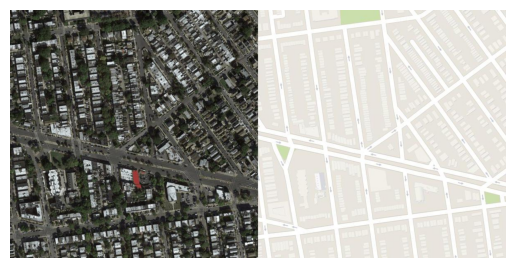

In [3]:
# Ejemplo:
img = Image.open('/content/data/maps/train/1.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

- ¿Cómo fue construido el dataset `maps`? Esta información se puede encontrar en el paper del modelo `pix2pix`.
> **Respuesta:**
  El dataset _maps_ fue construido a partir de imágenes aéreas de Nueva York y alrededores extraídas de Google Maps.

- Para descargar los datos se usó la biblioteca `gdown`, pero se podría haber montado la unidad de Google Drive para hacerlo. ¿Cuál es la ventaja y desventaja de cada enfoque? ¿Cuándo convendría montar la unidad de Google Drive en vez de usar `gdown`?
> **Respuesta:**
  - _Ventajas:_
  1. Evita configuraciones manuales lo que resulta útil en caso de descargar archivos de gran tamaño.
  2. Fácil de usar.
  3. Facilita la automatización, i.e facilita el acceso de scripts a recursos externos.
  - _Desventajas:_
  1. depende de Google Drive, i.e de la ubicación de los archivos en la nube.
  2. Tiene límite de descargas, pudiendo generar inconvenientes a los usuarios un archivo si se descarga muchas vces.
  3.  No funciona con carpetas directamente (se deben descargar los archivos por separado). \\
  - Dado que _gdown_ permite descargar archivos o carpetas de un Drive público, cuando se quiera acceder a archivos privados se debería montar una unidad de Google Drive.



### Transformaciones para data augmentation

Se observa que cada archivo de imagen consiste en la concatenación horizontal de las imágenes $x_0$ y $x_1$, por lo que hay que separar el par de imágenes $(x_0,x_1)$ manualmente. Esto se realizará posteriormente en la clase `MapsDataset`. Antes de esto, se debe implementar la clase `PairedTransforms`, cuyo objetivo es aplicar una transformación (p.g. para data augmentation) de forma sincronizada sobre un par de muestras $(x_0,x_1)$, lo cual es necesario para un buen entrenamiento (p.g., si $x_0$ se refleja horizontalmente, $x_1$ también debe hacerlo).

- Implemente el método `__call__` de la clase `PairedTransforms`, la cual busca aplicar una misma transformación (p.g. `transforms.ToTensor`) a dos imágenes. Notar que algunas transformaciones tienen una componente aleatoria (p.g. `transforms.RandomCrop`), la cual se debe fijar para aplicar exactamente la misma transformación sobre $x_0$ y $x_1$.

In [4]:
import random

class PairedTransforms:
    # clase para data augmentation
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x0, x1):
      # aplica una transformacion a 2 imágenes

      # Uso una semilla por si la transformación tiene una componente aleatoria
      seed = torch.seed()
      random.seed(seed)
      torch.manual_seed(seed)

      x0 = self.transform(x0)

      # con esto me aseguro de aplicar la misma transformacion a ambas imagenes
      random.seed(seed)
      torch.manual_seed(seed)
      x1 = self.transform(x1)
      return x0, x1

### Clase `MapsDataset`

La siguiente clase permite obtener pares de entrenamiento $(x_0,x_1)$ para poder entrenar el modelo `pix2pix`. El método `__getitem__` divide la imagen obtenida en $(x_0, x_1)$ y luego aplica la transformación `transform` recibida en el constructor al par de imágenes $(x_0,x_1)$ utilizando la clase `PairedTransforms` recién implementada:

In [5]:
class MapsDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_filenames = [file for file in os.listdir(root_dir) if file.endswith('jpg')]
        self.transform = PairedTransforms(transform)

    def __len__(self):
        return len(self.data_filenames)

    def __getitem__(self, n):
        img_path = os.path.join(self.root_dir, self.data_filenames[n])
        image = Image.open(img_path).convert('RGB')

        w, h = image.size
        x0 = image.crop((0, 0, w//2, h))
        x1 = image.crop((w//2, 0, w, h))

        if self.transform:
            x0, x1 = self.transform(x0, x1)

        return x0, x1

- En la siguiente celda, modifique la transformación `train_transform` para incluir técnicas de data augmentation. Debe incluir al menos 2 técnicas de data augmentation.

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5), # p=1 fuerza la prob de voltear la imagen
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5), # p=1 fuerza la prob de voltear la imagen
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

- ¿Por qué eligió esas transformaciones? ¿Son compatibles con la tarea que busca aprender el modelo `pix2pix` o pueden ser contraproducentes en el entrenamiento?
> **Respuesta:**
1. RandomHorizontalFlip() solo da vuelta la imagen sin modificarla mayormente, es compatible con pix2pix ya que con la modificación hecha a la clase PairedTransformations nos aseguramos de que las transformaciones se apliquen de igual forma a ambas imágenes por lo que no debería generar problemas.
2. RandomCrop() permite extraer una región aleatoria de tamaño fijo de la imagen, además dado que la transformación no afecta el alineamiento ya que se puede aplicar de manera sincronizada a los pares de imágenes lo que la hace compatible con pix2pix.

- ¿Cuál es el objetivo de la transformación `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`? ¿Por qué esta normalización se aplica al final?
> **Respuesta:**
`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` busca aplicar una normalización de media y desviación estándar igual a 0.5 en cada canal. La primera tupla de valores da cuenta de las medias a considerar por cada canal, mientras que la segunda tupla da cuenta de las desviaciones estándar.
La normalización actúa sobre *tensores*, no sobre imágenes y, dado que en el penúltimo paso se transformó a tensor, entonces corresponde que el último paso sea normalizar.



In [7]:
train_dataset = MapsDataset(root_dir='/content/data/maps/train', transform=train_transform)
eval_dataset = MapsDataset(root_dir='/content/data/maps/val', transform=eval_transform)

# Test:
x0, x1 = train_dataset[0]
assert x0.shape == x1.shape == (3, 256, 256)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=10, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)

print(f'Dataset de entrenamiento: {len(train_dataset)} muestras.')
print(f'Dataset de validación: {len(eval_dataset)} muestras.')

Dataset de entrenamiento: 1096 muestras.
Dataset de validación: 1098 muestras.


- ¿Cuál es la función de los parámetros `num_workers` y `pin_memory` al definir los dataloaders? ¿Por qué se utiliza `drop_last=True`?
> **Respuesta:**
- *num_workers*: permite especificar el número de procesos en paralelo que se ejecutarán para carga de datos. -> Ventaja: agiliza la velocidad de carga.
- *pin_workers*: determina si se reserva un espacio fijo en la RAM para que la transferencia del tensor al GPU sea rápida y directa, de esa forma la GPU no tiene que esperar por datos.
- *Drop_last*: se utiliza como "buena práctica" para evitar que se pueda tener un batch incompleto, por ejemplo un batch de 1 imagen en lugar de 10 imágenes.

### Visualización

En la siguiente celda, la función `show_batch` permite verificar que las implementaciones realizadas hasta el momento son correctas (i.e., las técnicas de data augmentation se aplican de forma sincronizada sobre $(x_0,x_1)$ y son compatibles con la tarea que se busca que aprenda el modelo). Es importante notar que para visualizar imágenes de este dataset, es necesario deshacer la normalización `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` para que los valores de los tensores estén en los rangos esperado. Esto se logra con la función `denormalize`.

In [8]:
def denormalize(batch):
    return (batch + 1).clamp(0, 2) / 2

def show_batch(x0, x1, x1_pred=None, n_images=4):

    x0 = denormalize(x0)
    x1 = denormalize(x1)
    x1_pred = denormalize(x1_pred) if x1_pred is not None else None

    n_cols = 3 if x1_pred is not None else 2
    plt.figure(figsize=(n_cols * 2, 2 * n_images))

    for n in range(n_images):

        # Imagen original:
        plt.subplot(n_images, n_cols, n_cols * n + 1)
        plt.imshow(x0[n].permute(1, 2, 0))
        plt.axis('off')
        plt.title(r'$x_0$')

        # Transformación esperada:
        plt.subplot(n_images, n_cols, n_cols * n + 2)
        plt.imshow(x1[n].permute(1, 2, 0))
        plt.axis('off')
        plt.title(r'$x_1$')

        # Transformación predicha:
        if x1_pred is not None:
            plt.subplot(n_images, n_cols, n_cols * n + 3)
            plt.imshow(x1_pred[n].permute(1, 2, 0))
            plt.axis('off')
            plt.title(r'$\tilde x_1$')

    plt.tight_layout()
    plt.show()

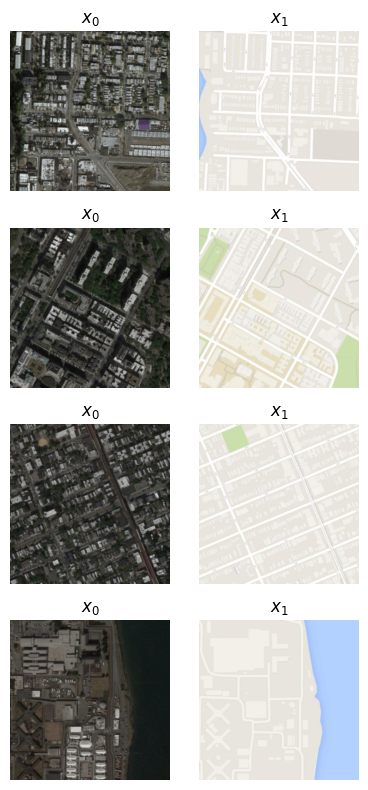

In [9]:
x0, x1 = next(iter(train_dataloader))
show_batch(x0, x1)

## Parte 2 (redes neuronales)

En esta segunda parte se implementarán las redes neuronales asociadas al generador $G$ (U-Net adaptada para GANs) y al discriminador $D$ (PatchGAN) del modelo `pix2pix`.

Es importante destacar que, si bien la formulación del modelo `pix2pix` indica que el generador $G$ depende tanto de la imagen inicial $x_0$ como la variable latente $z$, en la práctica es usual que la red neuronal asociada a $G$ solo reciba $x_0$, mientras que la aleatoriedad suele ser inyectada usando dropout.

Por otro lado, dado que las GANs suelen tener un entrenamiento inestables debido a su dinámica de entrenamiento adversativa, es usual tener que incluir heurísticas tanto en la arquitectura como en la optimización. Para efectos de esta tarea, la efectividad de las heurísticas utilizadas se puede decidir por inspección visual de las curvas de entrenamiento y de las imágenes generadas.

### Generador

- Modifique las clases `ConvBlock`, `DownBlock`, `UpBlock` y/o `UNet` de la [arquitectura U-Net estudiada en clases](https://github.com/fernando-fetis/MDS7203/blob/main/Clases/Clase%2011/notebooks/unet.ipynb) para que incluya dropout y algunas heurísticas de arquitectura que ayuden a estabilizar el entrenamiento. Para esto, puede probar con heurísticas que crea que deberían funcionar bien (i.e., ensayo/error) o con heurísticas que ya se conozcan de otros trabajos (p.g., [DCGAN](https://arxiv.org/abs/1511.06434)).

In [10]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # nn.InstanceNorm2d(out_channels),  # <--- FALTA ESTO
            nn.LeakyReLU(0.001, inplace=False),

            nn.Dropout2d(dropout),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # nn.InstanceNorm2d(out_channels),  # <--- FALTA ESTO
            nn.LeakyReLU(0.01, inplace=False) # utilizada para suavizar y estabilizar aprendizaje

         # Para estabilizar el entrenamiento, se normalizará usando InstanceNorm2d,
         # este normaliza cada muestra por separado, un canal a la vez. Esto,
         # lo hace muy útil para la transferencia de estilo o generación de imagenes.,
         # Contra: Es lento pero con mayor consistencia en cuanto a tareas generativas.
            )


    def forward(self, x):
        return self.conv(x)

# ------------------------------------------------------------------------------------------
class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        # self.down = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.down = nn.MaxPool2d(kernel_size=2)

        # Conv con stride>2 permite que se muevan 2 pixeles a la vez
        # Ventaja: mejora la fluidez del gradiente y evita pérdidas de info abruptas
        # MaxPool podría generar pérdidas de info, afectando su detección de detalles finos
        # self.down = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv(x)
        output = self.down(skip)
        return output, skip

# ------------------------------------------------------------------------------------------

class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, dropout)
        # Usar dropout=0, es equivalente a no aplicarlo
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
       x = self.up(x)
       x = torch.cat([x, skip], dim=1)
       return self.conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels, n_classes, base_ch=64):
        super().__init__()

        # No se normaliza en la primera capa
        self.down1 = DownBlock(in_channels, base_ch)
        self.down2 = DownBlock(base_ch, base_ch*2)
        self.down3 = DownBlock(base_ch*2, base_ch*4)
        self.down4 = DownBlock(base_ch*4, base_ch*8)

        self.bottleneck = ConvBlock(base_ch*8, base_ch*16)

        self.up4 = UpBlock(base_ch*16, base_ch*8)
        self.up3 = UpBlock(base_ch*8, base_ch*4)
        self.up2 = UpBlock(base_ch*4, base_ch*2)
        self.up1 = UpBlock(base_ch*2, base_ch)

        # self.out = nn.Sequential(
        #     nn.Conv2d(base_ch, n_classes, kernel_size=1),
        #     nn.Tanh()) #para normalizar las imágenes entre -1 y 1

        self.out = nn.Conv2d(base_ch, n_classes, kernel_size=1)


    def forward(self, x):
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)

        x = self.bottleneck(x)

        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)

        return self.out(x)

- ¿Cuáles fueron las heurísticas que incluyó? ¿Por qué utilizó estas heurísticas?
> **Respuesta:**

### Discriminador

Para modelar el discriminador $D$, se utilizara la siguiente red convolucional llamada _PatchGAN_:

In [11]:
class PatchGAN(nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=True)
        )

    def forward(self, x0, x1):
        x = torch.cat([x0, x1], dim=1)
        return self.model(x)

- ¿Cuál es la diferencia principal entre la arquitectura PatchGAN y un clasificador de imágenes usual? ¿Por qué es mejor usar una PatchGAN para `pix2pix`?
> **Respuesta:**

## Parte 3 (entrenamiento y generación)

En esta última parte se entrenará el modelo `pix2pix` implementado en la parte 2 utilizando el dataset implementado en la parte 1.

### Inicialización

La siguiente función se utilizará para inicializar los parámetros de las redes definidas anteriormente:

In [12]:
def init_weights(module):

    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(module.weight.data, 0.0, 0.02)

    elif isinstance(module, nn.InstanceNorm2d):
        if module.weight is not None:
            nn.init.normal_(module.weight.data, 1.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias.data, 0.0)

### Función de costo

Si bien el método de entrenamiento para el modelo `pix2pix` es similar al de una GAN estándar, es necesario adaptar el cálculo de la función de pérdida a la función de pérdida utilizada por `pix2pix`. Recordar que la función de pérdida usada por este modelo viene dada por

$$
\mathcal{L}(G,D)=
\mathbb{E}_{x_0,x_1}\left[\log D(x_0,x_1)\right] + \mathbb{E}_{x_0,z}\left[\log \left(1-D(x_0,G(x_0,z))\right)\right]
+ \lambda\cdot\mathbb{E}_{x_0,x_1,z}\left[\left\|x_1-G(x_0,z)\right\|_1\right],
$$

donde $x_0$ es la imagen que se busca transformar, $x_1$ es la transformación real y $z$ es la variable latente del modelo generativo $G$ (i.e., $\tilde x_1=G(x_0,z)$ es la transformación de $x_0$ aprendida por el modelo generador $G$). El hiperparámetro $\lambda>0$ es un escalar positivo.

- ¿En qué se diferencia esta función objetivo de la función objetivo de una GAN clásica?
> **Respuesta:**
- ¿Qué evalúa cada término de $\mathcal{L}(G,D)$? ¿Cuál es el motivo para preferir la función de pérdida $L^1$ en vez de la función de pérdida $L^2$ en el término $\mathbb{E}_{x_0,x_1,z}\left[\left\|x_1-G(x_0,z)\right\|_1\right]$?
> **Respuesta:**
- ¿Qué trade-off se genera al variar el hiperparámetro $\lambda$?
> **Respuesta:**
- ¿En qué se diferencia esta función de pérdida de la función de pérdida usada en [CycleGAN](https://arxiv.org/abs/1703.10593)?
> **Respuesta:**

Como se comentó anteriormente, en la práctica, es usual considerar $G(x_0,z)=G(x_0)$ (i.e., no se incluye explícitamente una variable latente en la implementación). Además, al calcular la función de pérdida $\mathcal{L}(G,D)$ para optimizar $G$, se suele usar $- \mathbb{E}_{x_0}\left[\log D(x_0,G(x_0))\right]$ en vez de $\mathbb{E}_{x_0}\left[\log \left(1-D(x_0,G(x_0))\right)\right]$.

- ¿Por qué se prefiere optimizar esta cantidad? ¿Por qué solo se utiliza esto para el generador y no para el discriminador?
> **Respuesta:**

### Bucle de entrenamiento

- Complete la siguiente función de entrenamiento (puede basarse en la [función de entrenamiento vista en clases](https://github.com/fernando-fetis/MDS7203/blob/main/Clases/Clase%209/notebooks/DCGAN.ipynb)) para entrenar el modelo `pix2pix` utilizando $\mathcal{L}(G,D)$ con las modificaciones mencionadas. Averigüe sobre las decisiones de diseño (optimizadores, schedulers, valores para $\lambda$) que funcionan bien para entrenar modelos tipo GANs. Si prefiere, puede incluir heurísticas que ayuden en el entrenamiento de las GANs (p.g. inyectar ruido a las imágenes o a las etiquetas). No olvide guardar los `state_dict` de $G$ y $D$ en la parte de early stopping.

In [13]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [31]:
def train_pix2pix(G, D, train_dataloader, val_dataloader, n_epochs, init_fn=init_weights, patience=10):
    G = G.to(DEVICE).apply(init_fn)
    D = D.to(DEVICE).apply(init_fn)

    optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    scheduler_G = StepLR(optimizer_G, step_size=10, gamma=0.5)
    scheduler_D = StepLR(optimizer_D, step_size=10, gamma=0.5)

    dataloaders = {'train': train_dataloader, 'eval': val_dataloader}
    losses = {'train': {'G': [], 'D': []}, 'eval': {'G': [], 'D': []}}
    training_log = {'G': None, 'D': None, 'losses': losses}

    patience_counter = 0
    best_eval_loss = float('inf')
    delta = 1e-5

    loss_fn = nn.BCEWithLogitsLoss()

    try:
        for epoch in range(n_epochs):
            for mode in ('train', 'eval'):
                # is_train = (mode == 'train')
                G.train(mode == 'train')
                D.train(mode == 'train')

                sum_loss_G, sum_loss_D = 0.0, 0.0

                for x0, x1 in tqdm(dataloaders[mode], desc=f'Época {epoch+1}/{n_epochs} [{mode}]', leave=False):
                    x0, x1 = x0.to(DEVICE), x1.to(DEVICE)

                    with torch.set_grad_enabled(mode == 'train'):

                        x1_generated = G(x0)

                        compare_real = D(x0, x1)
                        compare_fake = D(x0, x1_generated.detach())

                        real_labels = torch.ones_like(compare_real).to(DEVICE)
                        fake_labels = torch.zeros_like(compare_fake).to(DEVICE)

                        loss_real = loss_fn(compare_real, real_labels)
                        loss_fake = loss_fn(compare_fake, fake_labels)
                        loss_D = 0.5 * (loss_real + loss_fake)

                        if mode == 'train':
                          optimizer_D.zero_grad()
                          loss_D.backward()
                          optimizer_D.step()

                        compare_fake_G = D(x0, x1_generated)

                        loss_G_adv = loss_fn(compare_fake_G, real_labels)
                        loss_G_l1 = F.l1_loss(x1_generated, x1)
                        lambda_l1 = 100
                        loss_G = loss_G_adv + lambda_l1 * loss_G_l1

                        if mode == 'train':

                          optimizer_G.zero_grad()
                          loss_G.backward()
                          optimizer_G.step()

                    sum_loss_G += loss_G.item()
                    sum_loss_D += loss_D.item()

                losses[mode]['G'].append(sum_loss_G / len(dataloaders[mode]))
                losses[mode]['D'].append(sum_loss_D / len(dataloaders[mode]))

                if mode == 'train':
                    scheduler_G.step()
                    scheduler_D.step()

            # Early stopping

            if losses['eval']['G'][-1] < best_eval_loss:
                patience_counter = 0
                best_eval_loss = losses['eval']['G'][-1] # actualizamos el parametro de comparacion

                training_log['G'] = G.state_dict()
                training_log['D'] = D.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping por paciencia en época {epoch+1}.")
                break

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    torch.save(training_log, 'training.pt')


### Pruebas

In [ ]:
# def train_pix2pix(G, D, train_dataloader, val_dataloader, n_epochs, init_fn=init_weights, patience=10):
#     G = G.to(DEVICE).apply(init_fn)
#     D = D.to(DEVICE).apply(init_fn)

#     optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
#     optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

#     scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.5)
#     scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.5)

#     dataloaders = {'train': train_dataloader, 'eval': val_dataloader}
#     losses = {'train': {'G': [], 'D': []}, 'eval': {'G': [], 'D': []}}
#     training_log = {'G': None, 'D': None, 'losses': losses}
#     patience_counter = 0

#     loss = nn.BCEWithLogitsLoss()

#     try:
#         for epoch in range(n_epochs):
#             for mode in ('train', 'eval'):
#                 G.train(mode == 'train')
#                 D.train(mode == 'train')

#                 sum_loss_G, sum_loss_D = 0.0, 0.0

#                 for x0, x1 in tqdm(dataloaders[mode], desc=f'Época {epoch+1}/{n_epochs} [{mode}]', leave=False):
#                     x0, x1 = x0.to(DEVICE), x1.to(DEVICE)

#                     with torch.set_grad_enabled(mode == 'train'):
#                         fake_image = G(x0)
#                         fake_image_clone = fake_image.clone()

#                         print(fake_image_clone.requires_grad)
#                         print(fake_image_clone.is_leaf)
#                         print(fake_image_clone.grad_fn)


#                         # Discriminador
#                         pred_fake = D(x0, fake_image_clone)
#                         pred_real = D(x0, x1)


#                         real_labels = torch.ones_like(pred_real).to(DEVICE)
#                         fake_labels = torch.zeros_like(pred_fake).to(DEVICE)


#                         loss_fake = loss(pred_fake, fake_labels)
#                         loss_real = loss(pred_real, real_labels)

#                         loss_D = 0.5 * (loss_real + loss_fake)

#                         # Generador
#                         pred_fake_G = D(x0, fake_image_clone)
#                         loss_G_adv = loss(pred_fake_G, real_labels)

#                         loss_G_l1 = F.l1_loss(fake_image, x1)

#                         lambda_l1 = 100
#                         loss_G = loss_G_adv + lambda_l1 * loss_G_l1

#                         if mode == 'train':
#                             optimizer_D.zero_grad()
#                             loss_D.backward(retain_graph=True)
#                             optimizer_D.step()

#                             optimizer_G.zero_grad()
#                             loss_G.backward()
#                             optimizer_G.step()

#                     sum_loss_G += loss_G.item()
#                     sum_loss_D += loss_D.item()

#                 losses[mode]['G'].append(sum_loss_G / len(dataloaders[mode]))
#                 losses[mode]['D'].append(sum_loss_D / len(dataloaders[mode]))

#                 if mode == 'train':
#                     scheduler_G.step()
#                     scheduler_D.step()

#             # Early stopping
#             if losses['eval']['G'][-1] == min(losses['eval']['G']):
#                 training_log['G'] = G.state_dict()
#                 training_log['D'] = D.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

#             if patience_counter == patience:
#                 print("Parando temprano por paciencia.")
#                 break

#     except KeyboardInterrupt:
#         print('Entrenamiento interrumpido.')

#     torch.save(training_log, 'training.pt')


In [ ]:
# def train_pix2pix(G, D, train_dataloader, val_dataloader, n_epochs, init_fn=init_weights, patience=10):

#     # Redes neuronales:
#     G = G.to(DEVICE).apply(init_fn)
#     D = D.to(DEVICE).apply(init_fn)

#     # Optimizadores:
#     # Revisar la tasa de aprendizaje y modificarla si uno de los 2 aprende más rapido
#     optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
#     optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))


#     # Schedulers:
#     # Son utilizados para ajustar dinamicamente el learning rate durante el entrenamiento
#     # StepLR : reduce el lr cada step_size épocas -> Contra: es brusco
#     scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.5)
#     scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.5)

#     dataloaders  = {'train': train_dataloader, 'eval': val_dataloader}

#     losses = {'train': {'G': [], 'D': []}, 'eval': {'G': [], 'D': []}}
#     training_log = {'G': None, 'D': None, 'losses': losses}

#     # Entrenamiento y validación:
#     try:
#         for epoch in range(n_epochs):

#             for mode in ('train', 'eval'):

#                 G.train(mode == 'train')
#                 D.train(mode == 'train')

#                 sum_loss_G, sum_loss_D = 0.0, 0.0

#                 for x0, x1 in tqdm(dataloaders[mode], desc=f'Época {epoch+1}/{n_epochs} [{mode}]', leave=False):
#                     x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
#                     print(1)
#                     # x0 : imagen area
#                     # x1 : imagen del mapa
#                     # Se busca transformar x0 en x1 -> hacer que G(x0) parezca x1

#                     with torch.set_grad_enabled(mode == 'train'):
#                         # Loss_D -> -log-likelihood(imag real vs falsa)
#                         # Al usar detach evito que se calculen los gradientes asociados a G(x0)
#                         print(2)
#                         fake_image = G(x0)

#                         fake_image = fake_image.to(x1.device)
#                         print(2)
#                         real_labels = torch.ones_like(D(x0, x1))  # etiqueta: imagen real
#                         fake_labels = torch.zeros_like(D(x0, fake_image))  # etiqueta 0 para imágenes generadas
#                         print(3)
#                         loss_fake = F.binary_cross_entropy_with_logits(D(x0, fake_image.detach()), real_labels)
#                         loss_real = F.binary_cross_entropy_with_logits(D(x0, x1), fake_labels)

#                         print(4)
#                         loss_D = 0.5 * (loss_real + loss_fake)
#                         print(5)

#                         # Loss_G -> diferencia absoluta entre imag generada vs real +
#                         #            adverasarial loss

#                         loss_G_adv = F.binary_cross_entropy(D(x0, fake_image), real_labels)
#                         loss_G_l1 = F.l1_loss(fake_image, x1)

#                         lambda_l1 = 100
#                         loss_G = loss_G_adv + lambda_l1 * loss_G_l1
#                         # loss_G = ...

#                     sum_loss_G += loss_G.item()
#                     sum_loss_D += loss_D.item()

#                 losses[mode]['G'].append(sum_loss_G / len(dataloaders[mode]))
#                 losses[mode]['D'].append(sum_loss_D / len(dataloaders[mode]))

#                 if mode == 'train':
#                     scheduler_G.step()
#                     scheduler_D.step()

#             # Early stopping:
#             if losses['eval']['G'][-1] == min(losses['eval']['G']):
#                 training_log['G'] = G.state_dict()
#                 training_log['D'] = D.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

#             if patience_counter == patience:
#                 break


#     except KeyboardInterrupt:
#         print('Entrenamiento interrumpido.')

#     torch.save(training_log, 'training.pt')

### Entrenamiento

Se entrenará el modelo usando la función anterior. Notar que puede ser necesario redefinir el `batch_size` de los dataloaders para no tener problemas de memoria. Se recomienda probar la generación con pocas iteraciones (p.g. una época) para verificar si todo está bien implementado antes de realizar el entrenamiento completo.

In [32]:
  # Redes neuronales:
generator = UNet(in_channels=3, n_classes=3)
discriminator = PatchGAN(in_channels=3)

# Entrenamiento:
train_pix2pix(generator, discriminator, train_dataloader,
              eval_dataloader, n_epochs=10)

Se visualizarán las curvas de entrenamiento:

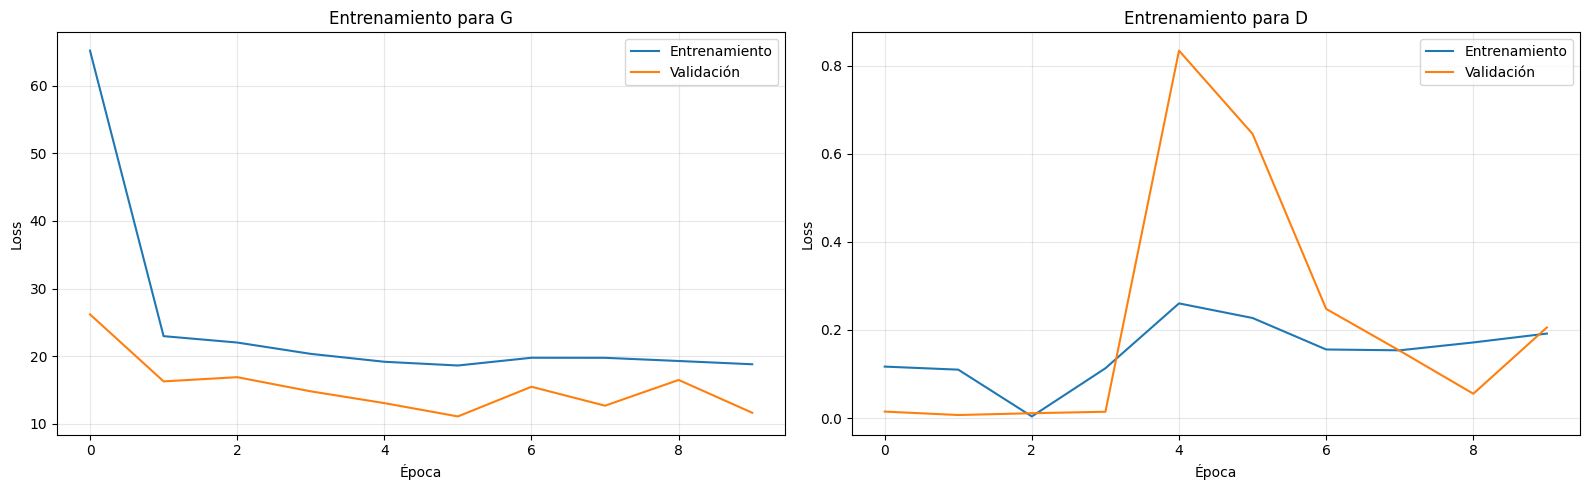

In [33]:
ckpt = torch.load('training.pt', map_location=DEVICE)
generator.load_state_dict(ckpt['G'])
discriminator.load_state_dict(ckpt['D'])

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
for ax, model in zip(axs, ('G', 'D')):
    ax.plot(ckpt['losses']['train'][model], label='Entrenamiento')
    ax.plot(ckpt['losses']['eval'][model], label='Validación')
    ax.set_title(f'Entrenamiento para {model}')
    ax.set_xlabel('Época')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- Intente explicar el comportamiento que observa en las funciones de pérdida del generador y del discriminador.
> **Respuesta:**

### Generación

Con el modelo entrenado, se comparará la transformación generada $\tilde x_1$ con la transformación real $x_1$ para algunas muestras $x_0$ del conjunto de validación.

In [34]:
def generate(generator, x0):

    generator.eval()
    x0 = x0.to(DEVICE)
    G = generator.to(DEVICE)

    with torch.no_grad():
        x1_pred = G(x0)

    return x1_pred

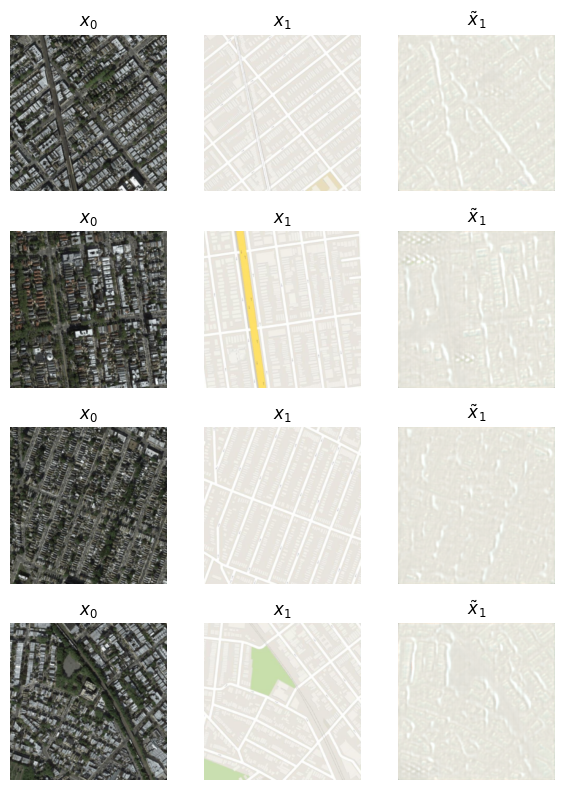

In [35]:
x0, x1 = next(iter(eval_dataloader))

x1_pred = generate(generator, x0).detach().cpu()
show_batch(x0, x1, x1_pred)

Si el modelo fue entrenado correctamente, las imágenes `x1` y `x1_pred` deben ser similares.